In [1]:
import tqdm
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import spatial

from basic.pi_n_xsec_net import TrainConfig, PiPlusNElectroproductionRegressor

## Load NN eval on whole ds

In [2]:
ckpt_path = "/Users/golda/Documents/Study/pi_n_xsec/final_results/pi_plus_n_layers_21_params_4974k_v1766014234_MAID/csv/version_0/checkpoints/epoch=99-step=18500.ckpt"
data_path = '/Users/golda/Documents/Study/pi_n_xsec/data/df_maid_as_exp.csv'
device = "cuda" if torch.cuda.is_available() else "cpu"

def prepare_model_and_scaling(pipe, ckpt_path: str, device: str = device):
    """
    Returns:
        net        - torch model in eval mode
        y_mean     - float
        y_scale    - float
    """

    ckpt = torch.load(ckpt_path, map_location="cpu")
    state = ckpt["state_dict"]

    net = pipe._build_network().to(device).eval()
    net.load_state_dict(
        {k.replace("model.", "", 1): v for k, v in state.items() if k.startswith("model.")}
    )

    y_mean = float(state["y_mean"])
    y_scale = float(state["y_scale"])

    return net, y_mean, y_scale

@torch.no_grad()
def predict_from_df(df, pipe, net, y_mean: float, y_scale: float, feature_scaler, device: str = device):
    """
    df  : pd.DataFrame with FEATURE_COLUMNS
    returns np.ndarray in original units
    """
    X = df[pipe.FEATURE_COLUMNS].to_numpy(dtype=np.float32)
    Xs = feature_scaler.transform(X)

    xb = torch.tensor(Xs, dtype=torch.float32, device=device)
    pred_scaled = net(xb).squeeze(-1).cpu().numpy()
    preds_scaled_inverse = pred_scaled * y_scale + y_mean

    return preds_scaled_inverse


In [4]:
cfg = TrainConfig(data_path=data_path)
cfg.run_name+='_MAID'
cfg.phi_to_rad=False
PiPlusNElectroproductionRegressor.LABEL_COLUMN = 'dsigma_dOmega_maid'
PiPlusNElectroproductionRegressor.DATA_COLUMNS = ["id","Ebeam", "W", "Q2", "cos_theta", "phi", "dsigma_dOmega",
                                                  "error", "weight", "dsigma_dOmega_maid"]

pipe = PiPlusNElectroproductionRegressor(cfg)
df = pipe.load_and_prepare_dataframe()

X = df[pipe.FEATURE_COLUMNS].to_numpy(dtype=np.float32)
pipe.feature_scaler.fit(X)
default_feature_scaler = pipe.feature_scaler

net, y_mean, y_scale = prepare_model_and_scaling(pipe=pipe, ckpt_path=ckpt_path, device=device)

df["pred_dsigma_dOmega"] = predict_from_df(df=df, pipe=pipe, net=net, y_mean=y_mean, y_scale=y_scale,   feature_scaler=default_feature_scaler, device=device)

df.head()

Seed set to 1438
wandb: Currently logged in as: golda (msu_ai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,weight,dsigma_dOmega_maid,cos_phi,pred_dsigma_dOmega
0,1.515,1.11,0.3,0.793353,0.261799,2.325,0.507275,1.971317,2.620328,0.965926,2.617812
1,1.515,1.11,0.3,0.382683,0.785398,1.704,0.496005,2.016110,2.699089,0.707107,2.661363
2,1.515,1.11,0.3,-0.130526,3.403392,3.681,0.545703,1.832498,4.505341,-0.965926,4.273657
3,1.515,1.13,0.3,0.608761,0.261799,1.149,0.523859,1.908910,1.709394,0.965926,2.660883
4,1.515,1.13,0.3,0.382683,5.497787,2.867,0.537034,1.862078,3.870077,0.707107,4.015551


In [6]:
df_maid = pd.read_csv('/Users/golda/Documents/Study/pi_n_xsec/data/df_maid_grid.csv')
df_maid.head()

,Unnamed: 0,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega_maid
0,0,5.754,1.1,1.615,-1.0,0.00,0.039741
1,1,5.754,1.1,1.615,-1.0,0.05,0.039741
2,2,5.754,1.1,1.615,-1.0,0.10,0.039741
3,3,5.754,1.1,1.615,-1.0,0.15,0.039741
4,4,5.754,1.1,1.615,-1.0,0.20,0.039741


## Generate grid

In [7]:
def generate_grid(step_W=0.005, step_Q2=0.1, step_cos_theta=0.1, step_phi=0.05):
    E_range = df.Ebeam.unique().tolist()

    data_grid = []
    for E in tqdm.tqdm(E_range):
        W_min = df[df.Ebeam==E].W.min() - 0.1
        W_max = df[df.Ebeam==E].W.max() + 0.1 + step_W

        Q2_min = df[df.Ebeam==E].Q2.min() - 0.1
        Q2_max = df[df.Ebeam==E].Q2.max() + 0.1 + step_Q2

        for W in np.arange(W_min, W_max, step_W):
            for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
                 for cos_theta in np.arange(-1, 1, step_cos_theta):
                        for phi in np.arange(0, 2*np.pi, step_phi):
                            data_grid.append([E,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)
    return df_grid

def generate_predictions_for_grid(df_grid, pipe, net, y_mean: float, y_scale: float):
    df_grid_parts = np.array_split(df_grid, 200)
    df_grid_parts_preds = []
    for df_grid_part in tqdm.tqdm(df_grid_parts):
        df_grid_part = pd.DataFrame(df_grid_part, columns=df_grid.columns)
        dsigma_dOmega_predicted = predict_from_df(df=df_grid_part, pipe=pipe, net=net, y_mean=y_mean, y_scale=y_scale, feature_scaler=default_feature_scaler, device=device)
        df_grid_part['dsigma_dOmega_predicted'] = abs(dsigma_dOmega_predicted)
        df_grid_parts_preds.append(df_grid_part)

    df_grid = pd.concat(df_grid_parts_preds)
    return df_grid

In [8]:
df_grid = generate_grid()
df_grid['cos_phi'] = np.cos(df_grid.phi)

100%|██████████| 3/3 [00:19<00:00,  6.37s/it]


In [9]:
df_grid = generate_predictions_for_grid(df_grid, pipe, net, y_mean=y_mean, y_scale=y_scale)

/Users/golda/Library/Caches/pypoetry/virtualenvs/pi-n-xsec-IYDaBAFH-py3.14/lib/python3.14/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 200/200 [03:28<00:00,  1.04s/it]


## Build phi graphs

In [86]:
df[(df.Ebeam==5.754)&
   (df.W==1.110)&
   (df.Q2==1.715)&
   (df.cos_theta==-0.1)]

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,cos_phi,pred_dsigma_dOmega
2324,5.754,1.11,1.715,-0.1,0.130900,0.24835,0.08115,0.991445,0.253184
2325,5.754,1.11,1.715,-0.1,0.392699,0.31508,0.08929,0.923880,0.309444
2326,5.754,1.11,1.715,-0.1,0.654498,0.33037,0.09702,0.793353,0.370297
2327,5.754,1.11,1.715,-0.1,0.916298,0.22582,0.05960,0.608761,0.378243


In [57]:
df_grid[(df_grid.Ebeam==5.754)&
        (df_grid.W==1.110)&
        (df_grid.Q2==1.715)&
        (df_grid.cos_theta==-0.1)&
        (df_grid.phi==0.4)]

,Ebeam,W,Q2,cos_theta,phi,cos_phi,dsigma_dOmega_predicted
3425822,5.754,1.11,1.715,-0.1,0.4,0.921061,0.200875


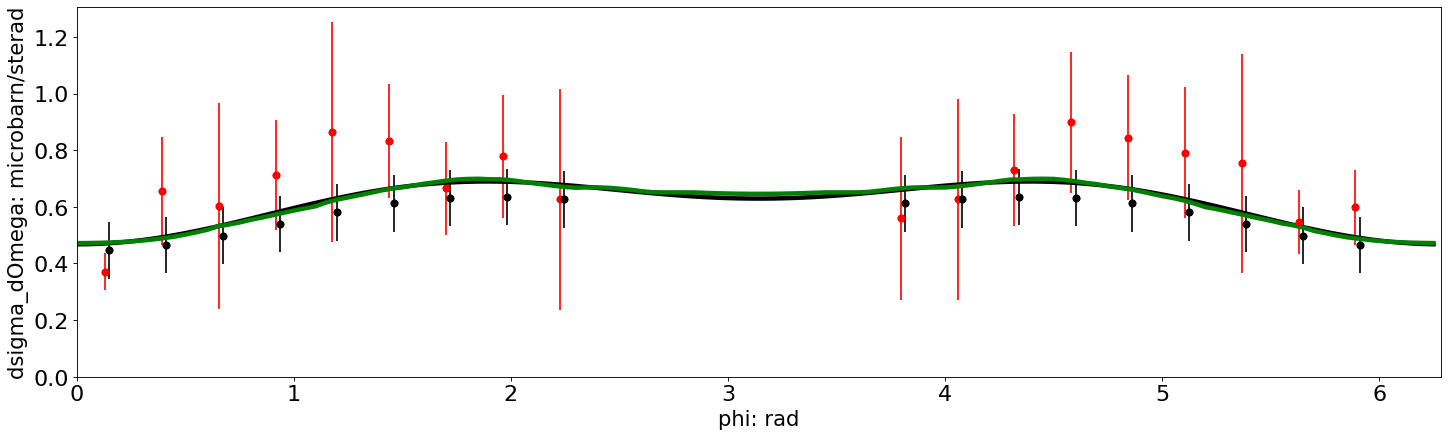

In [18]:
def find_closest(df_for_search, W_for_search, Q2_for_search):
    global closest_index
    closest_index = df_for_search[['W', 'Q2']].drop_duplicates(). \
                    apply(lambda x: spatial.distance.euclidean([W_for_search, Q2_for_search], [x.W, x.Q2]), axis=1).idxmin()
    assert isinstance(closest_index, tuple([int, np.int64]))
    return (df_for_search.loc[closest_index, 'W'], df_for_search.loc[closest_index, 'Q2'])

def plot_joint_cross_sections(df_maid, df_grid, df_maid_exp, E_beam, W, Q2, cos_theta):
    W_df_maid, Q2_df_maid = find_closest(df_maid, W, Q2)
    W_df_maid_exp, Q2_df_maid_exp = find_closest(df_maid_exp, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_maid_instance_set = df_maid[(df_maid.Ebeam == E_beam)&
                                    (df_maid.W == W_df_maid)&
                                    (df_maid.Q2 == Q2_df_maid)&
                                    (df_maid.cos_theta == cos_theta)].sort_values('phi')

    df_maid_exp_instance_set = df_maid_exp[(df_maid_exp.Ebeam == E_beam)&
                                           (df_maid_exp.W == W_df_maid_exp)&
                                           (df_maid_exp.Q2 == Q2_df_maid_exp)&
                                           (df_maid_exp.cos_theta == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W_df_grid)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (df_grid.cos_theta == cos_theta)].sort_values('phi')


    if len(df_maid_instance_set)==0:
        print(len(df_maid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_maid_instance_set)==0')

    if len(df_maid_exp_instance_set)==0:
        print(len(df_maid_exp_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_maid_exp_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')


    #input data
    xdata_real = df_maid_exp_instance_set.phi
    ydata_real = df_maid_exp_instance_set.dsigma_dOmega
    ydata_error_real = df_maid_exp_instance_set.error


    xdata_maid_exp = df_maid_exp_instance_set.phi
    ydata_maid_exp = df_maid_exp_instance_set.dsigma_dOmega_maid
    ydata_maid_exp_error = [0.1 for _ in range(len(xdata_maid_exp))]

    xdata_maid = df_maid_instance_set.phi
    ydata_maid = df_maid_instance_set.dsigma_dOmega_maid

    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted


    plt.figure(figsize=(22, 6), dpi=80)

    # plt.figtext(0.13, 0.83, f'Params (from_maid_grid, from_maid_as_exp, from_preds). W({W_df_maid},{W_df_maid_exp},{W_df_grid}); Q2({Q2_df_maid},{Q2_df_maid_exp},{Q2_df_grid})')
    #
    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='.', label=f"Experimental data. Params: Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}",
                linewidths=4)
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.scatter(x=xdata_maid_exp+0.02,
                y=ydata_maid_exp,
                color='black', marker='.', label=f"MAID data as exp. Params: Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}",
                linewidths=4)
    plt.errorbar(x=xdata_maid_exp+0.02,
                 y=ydata_maid_exp,
                 yerr=ydata_maid_exp_error,
                 color='black',
                 fmt='o')

    plt.plot(xdata_maid,
         ydata_maid,
         color='black',
         label=f'MAID data.',
        linewidth=4.0
         )


    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Predicted data trained on MAID data as exp',
             linewidth=4.0)

    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.tick_params(axis='both', which='major', labelsize=20)

    plt.xlabel("phi: rad", fontsize="19")
    plt.ylabel("dsigma_dOmega: microbarn/sterad", fontsize="19")

    # plt.legend(loc ="upper right", fontsize="15")
    # plt.savefig(f'./all_res/maid/cross_sections_exact/E_beam={E_beam}/Q2={Q2}/W={W}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')

    plt.show()
    plt.close()
    return None


plot_joint_cross_sections(df_maid=df_maid, df_maid_exp=df, df_grid=df_grid,
                          E_beam=5.754, W=1.745, Q2=2.05, cos_theta=0.3)

In [14]:
df.W.unique()

array([1.11 , 1.13 , 1.27 , 1.29 , 1.31 , 1.33 , 1.35 , 1.37 , 1.39 ,
       1.41 , 1.43 , 1.45 , 1.47 , 1.49 , 1.51 , 1.53 , 1.55 , 1.57 ,
       1.15 , 1.17 , 1.19 , 1.21 , 1.23 , 1.25 , 1.59 , 1.61 , 1.63 ,
       1.65 , 1.67 , 1.69 , 1.71 , 1.73 , 1.75 , 1.77 , 1.79 , 1.605,
       1.615, 1.625, 1.635, 1.645, 1.655, 1.665, 1.675, 1.685, 1.695,
       1.705, 1.715, 1.725, 1.735, 1.745, 1.755, 1.765, 1.775, 1.78 ,
       1.83 , 1.89 , 1.95 , 1.62 , 1.66 , 1.7  , 1.74 ])